# FS25 Course Project 1: Word embeddings / RNN

By David Hodel

## Introduction

In this notebook, I present my solution to the first course project of the FS25 NLP module @ HSLU.

The task is to train answer commonsense question using word embeddings and RNNs. The CommonsenseQA ([Talmor et al., 2019](https://aclanthology.org/N19-1421/)) dataset is used for his purpose. The dataset consists of 12,247 questions with 5 choices each, where only one is correct. The questions are designed to require commonsense reasoning to answer correctly.

## Setup

We first import the necessary libraries to run the code.

In [1]:
import logging

from collections import Counter
from datetime import datetime

from datasets import load_dataset
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from tqdm import trange
import fasttext
from huggingface_hub import hf_hub_download

import torch
import nltk
import wandb

We set up logging to get a better overview of the training process.

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

We set up a fixed random seed to ensure reproducibility.

In [3]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We download the necessary files for the tokenizer from the `nltk` library and pretrained weights for the fasttext embedding model.

In [5]:
nltk.download('punkt_tab')
model_path = hf_hub_download("facebook/fasttext-en-vectors", "model.bin")

[nltk_data] Downloading package punkt_tab to /home/david/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


I decided to use fasttext embeddings as they natively support out-of-vocabulary words as it uses subword information.

In [6]:
wv = fasttext.load_model(model_path)

### Data Splits

The data is available on Hugging Face: https://huggingface.co/datasets/tau/commonsense_qa.
Since only the train and validation splits have an answer key, we will use our own dataset splits.
We separate the last 1'000 samples from the training set as the validation set and use the original validation set as the test set.

In [7]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data Exploration

First, we want to take a look at the data to understand its structure and content.

In [8]:
datasets = {
  "train": train,
  "validation": valid,
  "test": test
}

We ensure that all three splits have the same structure and that the answers are in the same format.

In [9]:
print(train.column_names)
assert train.column_names == valid.column_names == test.column_names

print(train[0])

unique_answers = set([ex["answerKey"] for ex in train] + [ex["answerKey"] for ex in valid] + [ex["answerKey"] for ex in test])
print(f"Unique answer keys: {unique_answers}")

['id', 'question', 'question_concept', 'choices', 'answerKey']
{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}
Unique answer keys: {'A', 'B', 'C', 'D', 'E'}


We then display a sample question and its answer for each split to get a feeling of the type of questions and answers.

In [10]:
for split, data in datasets.items():
    print(f"\n=== {split} Split ===")
    print(f"Question: {data[0]['question']}")
    for j, choice in enumerate(data[0]['choices']['text']):
        print(f"{chr(65+j)}) {choice}")  # A, B, C, etc.
    print(f"Correct Answer: {data[0]['answerKey']}")
    print("=" * 50)


=== train Split ===
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A) ignore
B) enforce
C) authoritarian
D) yell at
E) avoid
Correct Answer: A

=== validation Split ===
Question: What is a well known way for couples  of celebrating a marriage?
A) eat cake
B) getting drunk
C) having sex
D) cleaning rooms
E) drink too much
Correct Answer: C

=== test Split ===
Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
A) bank
B) library
C) department store
D) mall
E) new york
Correct Answer: A


We plot the distribution of the answer keys (`A` - `E`) to see if there's a clear imbalance or pattern.

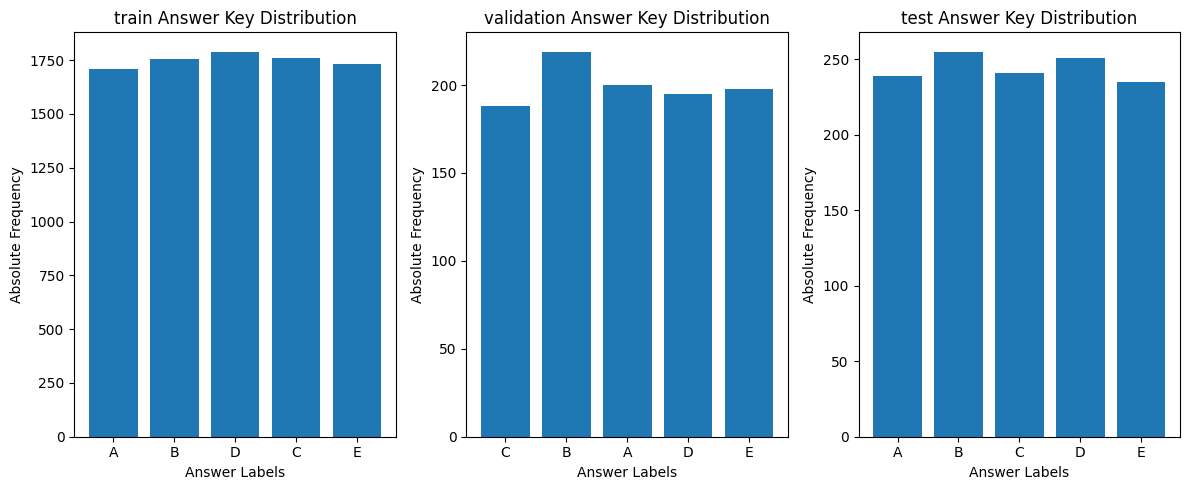

In [11]:
plt.figure(figsize=(12, 5))

for i, (split, data) in enumerate(datasets.items(), 1):
    answer_counts = Counter([ex["answerKey"] for ex in data])

    plt.subplot(1, 3, i)
    plt.bar(answer_counts.keys(), answer_counts.values())
    plt.xlabel("Answer Labels")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Answer Key Distribution")

plt.tight_layout()
plt.show()

We also plot the distribution of the number of characters in the questions.

Min. question length in split train: 15, max. length: 376
Min. question length in split validation: 20, max. length: 270
Min. question length in split test: 21, max. length: 279


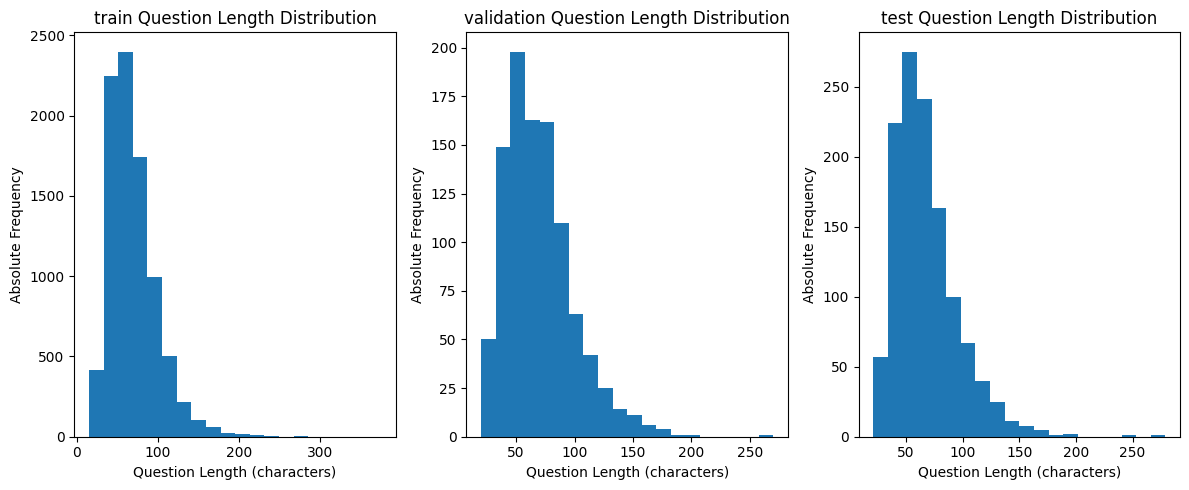

In [12]:
plt.figure(figsize=(12, 5))

for i, (split, data) in enumerate(datasets.items(), 1):
    question_lengths = [len(ex["question"]) for ex in data]

    plt.subplot(1, 3, i)
    plt.hist(question_lengths, bins=20)
    plt.xlabel("Question Length (characters)")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Question Length Distribution")
    print(f"Min. question length in split {split}: {min(question_lengths)}, max. length: {max(question_lengths)}")

plt.tight_layout()
plt.show()

## Preprocessing

Correct and justified decisions on:
o Tokenization
o Lowercasing, stemming, lemmatizing, stopword/punctuation removal
o Removal of unknown/other words
o Format cleaning (e.g. html-extracted text)
o Truncation
o Feature selection
o Input format: how is data passed to the model?
o Label format: what should the model predict?
o Batching, padding
o Vocabulary, embedding

First, we preprocess the raw text data to make it suitable for the model.

We use the word tokenizer from the `nltk` library to split the text into word tokens.

We don't lowercase the text as it may contain important information such as `I` or `US` and because fasttext can naturally handle different cases.

We also don't remove stopwords or punctuation as they may also contain important information for the model for answering the questions.

Stemming or lemmatization is not necessary as fasttext can handle different forms of words. Even more, it may be counterproductive as it may remove important information from the text such as time or location information.

Removal of unknown words is not necessary as fasttext word vectors are built from vectors of substrings of characters contained in it. This allows to build vectors even for misspelled words or concatenation of words.

As the longest question only has 376 characters, we don't need to truncate the text. During training we will use padding to ensure all strings have the same length.

The text in the dataset is already clean and doesn't contain any html tags we would need to remove and / or parse. 

In short: The only preprocessing we do is tokenization.

In [13]:
def preprocess_text(text):
  preprocessed = word_tokenize(text)
  return preprocessed

We then check out how the loaded embeddings look like and how many words are in the vocabulary.

In [14]:
print(f"Word embeddings vector size: {wv.get_dimension()}")
print(f"Word embeddings vocab size: {len(wv.words)}")

print(wv.words[:10])
print(wv.words[-5:])

Word embeddings vector size: 300
Word embeddings vocab size: 2000000
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']
['ldapmodify', 'sponde', 'hvm', 'GorceyBearTerritory.netSaturday', 'Zwicke']


Test the embeddings by looking up a word that certainly exists in the vocabulary and a word that doesn't exist in the vocabulary to see if it handles out-of-vocabulary words.

In [15]:
print(wv["and"])
print(wv["thiswordceratinlydoesntexist"])

[ 8.23911093e-03 -8.99027660e-02  2.65252870e-02 -8.55387747e-03
 -6.09397441e-02  6.75930129e-03  6.52322620e-02  1.06213633e-02
 -4.75259237e-02 -7.61148334e-03 -2.25875620e-03  9.08407965e-04
 -6.68869540e-03 -2.25828700e-02 -6.61593257e-03 -7.24807084e-02
  2.03068964e-02  2.14499757e-02 -5.07426150e-02  3.91916037e-02
  5.33207357e-02 -4.52754647e-03 -1.86902005e-03  5.57158291e-02
  1.46500766e-02 -5.70575595e-02  4.93949279e-04 -7.09158741e-03
  1.48559324e-02 -5.28307818e-02  2.84850523e-02 -4.96256426e-02
  2.22029127e-02  5.86468279e-02  2.13257503e-02  7.91368634e-03
  1.87332481e-02  9.18916687e-02 -2.77845450e-02  2.39473525e-02
  4.25748378e-02 -9.94171482e-03 -2.23485958e-02  8.55861679e-02
 -4.47648503e-02 -1.41877644e-02 -1.26887113e-04 -1.00239128e-01
 -1.24342320e-02  5.95488772e-02  2.35982426e-02  1.56282559e-02
  1.94263570e-02  8.58244579e-03  1.51532954e-02  4.16088402e-02
  1.98060516e-02 -7.46113062e-03 -3.07702627e-02 -2.10531931e-02
  2.74334885e-02 -4.17157

In [15]:
# only do this for the RNN

# embedding_dim = wv.vector_size

# special_tokens = {
#   "[EOQ]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of question
#   "[EOC1]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 1
#   "[EOC2]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 2
#   "[EOC3]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 3
#   "[EOC4]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 4
# }

# for token, vec in special_tokens.items():
#     assert token not in wv.key_to_index

# wv.add_vectors(list(special_tokens.keys()), list(special_tokens.values()))

### Torch Dataloader and Dataset

For the model to be able to train on the data, we need to create a custom torch dataset that we can read from a torch dataloader.

We create a dataset that, when indexed, returns data in the following format:
1. The question as a tensor with dimensions `(embedding_dim)`
2. The choices as a tensor with dimensions `(5, embedding_dim)`
3. The correct answer encoded as a number as a tensor with dimensions `(1)`

To be able to reduce each question and each choice to a single tensor, we need to have a method to reduce the word embeddings to a single tensor.

In this case, we will use the mean of the word embeddings to represent the sentences. Each sentence is first preprocessed by tokenizing it and is then converted to word embeddings. The mean of the word embeddings is then calculated to represent the sentence.

In [16]:
def get_averaged_sentence_embedding(sentence):
    """Convert a sentence into a fixed-size vector by averaging word embeddings."""
    tokens = preprocess_text(sentence)

    word_vectors = [wv[word] for word in tokens]
    return np.mean(word_vectors, axis=0)  # Average word vectors

To speed up training, we will precompute the embeddings for all questions and choices in the dataset using the `map()` function. The precomputed embeddings are then stored in separate columns in the dataset.

In [ ]:
def compute_embeddings(example):
    question_emb = get_averaged_sentence_embedding(example["question"])
    choice_embs = [get_averaged_sentence_embedding(choice) for choice in example["choices"]["text"]]
    
    # Save embeddings as lists so they can be stored in the dataset
    example["question_emb"] = question_emb.tolist()
    example["choice_embs"] = [emb.tolist() for emb in choice_embs]
    return example

train = train.map(compute_embeddings)
valid = valid.map(compute_embeddings)

Parameter 'function'=<function compute_embeddings at 0x7fae1c268280> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
2025-03-17 18:18:23,337 : WARNING : Parameter 'function'=<function compute_embeddings at 0x7fae1c268280> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and

Map:   0%|          | 0/8741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

We also need a function to convert the answer keys to numbers (`A` -> 0, `B` -> 1, ..., `E` -> 4).

In [18]:
def answer_key_to_index(answer_key):
  """Answer key (A-E) to index (0-4)"""
  return ord(answer_key) - ord("A")

Finally, we create our custom dataset that performs the preprocessing and returns the data in the format described above.

In [19]:
class CommonsenseQADataset(Dataset):
    def __init__(self, hf_dataset):
        self.data = hf_dataset
        # self.special_separator_tokens = { # only do this for the RNN
        #     "EOQ": wv["[EOQ]"],
        #     "EOC1": wv["[EOC1]"],
        #     "EOC2": wv["[EOC2]"],
        #     "EOC3": wv["[EOC3]"],
        #     "EOC4": wv["[EOC4]"],
        # }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_tensor = torch.tensor(example["question_emb"]).float()
        choices_tensor = torch.tensor(example["choice_embs"]).float()
        answer_index = answer_key_to_index(example["answerKey"])
        return question_tensor, choices_tensor, torch.tensor(answer_index).long()

In [20]:
train_dataset = CommonsenseQADataset(train)
valid_dataset = CommonsenseQADataset(valid)

We load the first sample from the dataset to check the dimensions of the returned data.

In [24]:
example_question_tensor, example_choices_tensor, example_answer_index = train_dataset[0]
print(example_question_tensor.shape, example_choices_tensor.shape, example_answer_index)

torch.Size([300]) torch.Size([5, 300]) tensor(0)


With this successful, we can now create a torch dataloader that reads from the custom dataset.

We use a batch size of 128. The data in the training set is shuffled to ensure that the model doesn't learn the order of the questions. The data in the validation and test set is not shuffled to ensure reproducibility.

In [25]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

We load the first batch from the dataloader to check the dimensions of the returned data and the format of the answers.

In [26]:
for batch in train_loader:
    print(batch[0].shape, batch[1].shape, batch[2].shape, batch[2])
    break

torch.Size([128, 300]) torch.Size([128, 5, 300]) torch.Size([128]) tensor([3, 3, 1, 4, 3, 4, 4, 4, 0, 2, 2, 3, 1, 3, 1, 4, 3, 4, 4, 4, 0, 1, 4, 2,
        3, 4, 3, 0, 1, 3, 0, 2, 1, 0, 1, 2, 2, 3, 1, 0, 2, 3, 4, 0, 2, 1, 3, 4,
        1, 1, 1, 1, 3, 1, 2, 1, 3, 4, 2, 4, 1, 1, 4, 2, 2, 2, 4, 2, 3, 1, 4, 3,
        0, 4, 1, 3, 4, 3, 1, 3, 3, 1, 4, 4, 4, 3, 4, 1, 4, 3, 4, 0, 3, 4, 2, 4,
        3, 4, 1, 0, 3, 1, 3, 0, 3, 4, 3, 1, 3, 1, 1, 3, 1, 3, 0, 0, 1, 1, 2, 3,
        2, 3, 1, 0, 2, 4, 0, 3])


## Model

The first model consists of two fully connected layers with a ReLU activation function in between.

It receives the question tensor (`(batch_size, embedding_dim)`) and the 5 choic tensors (`(batch_size, 5, embedding_dim)`) as input in the forward pass. The question tensor is then expanded to the same shape as the choice tensor and concatenated with it, resulting in a tensor of shape `(batch_size, 5, 2 * embedding_dim)`. This tensor is then passed through the two fully connected layers to get the logits for each choice (`(batch_size, 5)`).

Softmax is deliberately not applied to the logits because the chosen loss function, `CrossEntropyLoss`, already applies the softmax function to the logits.

In [27]:
class WordEmbeddingQAClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128):
        super(WordEmbeddingQAClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim) # the input dimension is doubled due to concatenation (question + choice)
        self.relu = nn.ReLU() # non-linearity
        self.fc2 = nn.Linear(hidden_dim, 1) # single score per candidate

    def forward(self, question, choices):
        # question: (batch_size, embedding_dim)
        # choices: (batch_size, 5, embedding_dim)

        # expand question to match the choices dimension
        question_expanded = question.unsqueeze(1).expand(-1, choices.size(1), -1) # (batch_size, 5, embedding_dim)
        
        # concatenate question and choice embeddings
        combined = torch.cat((question_expanded, choices), dim=2) # (batch_size, 5, 2*embedding_dim)

        # pass through the classifier
        x = self.fc1(combined)  # (batch_size, 5, hidden_dim)
        x = self.relu(x)
        x = self.fc2(x)         # (batch_size, 5, 1)
        return x.squeeze(-1)    # (batch_size, 5)

If available, we use a GPU for training.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
model = WordEmbeddingQAClassifier(embedding_dim=wv.get_dimension(), hidden_dim=64)
model = model.to(device)

print(model)

WordEmbeddingQAClassifier(
  (fc1): Linear(in_features=600, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


## Training

### Initialize Weights & Biases experiment tracking

For tracking the training process, we use Weights & Biases. We first have to log in to our account and initialize a new experiment.

In [30]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: davidhodel (dhodel-hslu-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [31]:
run = wandb.init(
  project="hslu-fs25-nlp-qa",
  entity="dhodel-hslu-nlp",
  name=f"word-embedding-qa-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "word-embedding",
    "embedding_dim": model.embedding_dim,
    "hidden_dim": model.hidden_dim,
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "epochs": 100
  }
)

To hook up the model to Weights & Biases, we call the `wandb.watch()` function and instruct it to watch the model.

In [ ]:
wandb.watch(model, log="all")

We use cross entropy loss as the loss function as it is well suited for multi-class classification tasks, such as this one.

As the optimizer we chose AdamW as it has been shown to perform well in practice. Its integrated weight decay is also beneficial as it helps to prevent overfitting.

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=run.config.learning_rate)

Finally, we can train the model: We iterate over the training set and calculate the loss for each batch. We then backpropagate the loss and update the weights of the model. After iterating over the entire training set, we evaluate the model on the validation set and log all relevant metrics to Weights & Biases.

In [33]:
num_epochs = run.config.epochs

for epoch in (pbar := trange(num_epochs)):
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    train_total_loss = 0.0
    train_correct = 0
    train_total = 0

    for question_batch, choices_batch, y_batch in train_loader:
        optimizer.zero_grad() # zero all the parameter gradients

        question_batch, choices_batch, y_batch = question_batch.to(device), choices_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(question_batch, choices_batch) # (batch_size, 5)

        # Compute loss
        train_batch_loss = criterion(outputs, y_batch)
        train_total_loss += train_batch_loss.item()

        # Compute accuracy
        train_predictions = torch.argmax(outputs, dim=1) # get most likely class
        train_correct += (train_predictions == y_batch).sum().item() # count correct predictions
        train_total += y_batch.size(0) # count total number of examples

        # Backward pass
        train_batch_loss.backward()
        optimizer.step()

    # Calculate train statistics
    avg_train_loss = train_total_loss / len(train_loader) # average loss per batch
    train_accuracy = train_correct / train_total # overall accuracy

    # Evaluate
    model.eval()
    val_correct = 0
    val_total  = 0
    val_total_loss  = 0

    with torch.no_grad():
        for question_batch, choices_batch, y_batch in valid_loader:
            question_batch, choices_batch, y_batch = question_batch.to(device), choices_batch.to(device), y_batch.to(device)

            val_outputs = model(question_batch, choices_batch) # (batch_size, 5)

            # Calculate validation loss
            val_batch_loss = criterion(val_outputs, y_batch)
            val_total_loss += val_batch_loss.item()

            val_predictions = torch.argmax(val_outputs, dim=1) # get most likely class
            val_correct += (val_predictions == y_batch).sum().item() # count correct predictions
            val_total += y_batch.size(0) # count total number of examples

    # Calculate validation statistics
    avg_val_loss = val_total_loss / len(valid_loader) # average loss per batch
    val_accuracy = val_correct / val_total # overall accuracy
    
    pbar.set_postfix({"train_loss": avg_train_loss, "train_acc": train_accuracy, "val_acc": val_accuracy})

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy,
        "learning_rate": optimizer.param_groups[0]['lr'], # current learning rate
    })

wandb.finish()

Epoch 100/100: 100%|██████████| 100/100 [04:51<00:00,  2.91s/it, train_loss=0.621, train_acc=0.826, val_acc=0.248]


epoch,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▂▂▃▂▄▃▁▃▄▅▆▆▆▄▆▇▆▅▄▇▇▅▆▇▇▇█▇▇▇█▆▆▆▇▇▆▆▆▆
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇█
epoch,99
learning_rate,0.001
train_accuracy,0.82622
train_loss,0.62064
val_accuracy,0.248


## Evaluation

## Interpretation